# Loading Data-Set

In [229]:
# Dataset loading
import os

dataset = "./New-Dataset/"
# dataset = "./Dataset (Labelled Images)/"
lab_files_path = dataset+"labels/"
# lab_files_path = dataset+"label/"

# total invoice files
files = os.listdir(lab_files_path)


# training set
Batch_1 = files[:45]

Batch_2 = files[45:60]

Batch_3 = files[60:70]

Batch_4 = files[70:75]

# validation set
valid_set = files[80:85]

# test set
test = files[95:100]

print("Total Label files are: ", len(files))
print("Training Batch-1 files are: ", len(Batch_1))
print("Training Batch-2 files are: ", len(Batch_2))
print("Validation files are: ", len(valid_set))
print("Testing files are: ", len(test))


Total Label files are:  110
Training Batch-1 files are:  45
Training Batch-2 files are:  15
Validation files are:  5
Testing files are:  5


# Geometric Algo

In [2]:
from PIL.Image import Image
from networkx.algorithms.shortest_paths.weighted import single_source_dijkstra
import matplotlib.pyplot as plt
from pandas.core.frame import DataFrame
from PIL import Image
import networkx as nx

df = 0
xMIN, xMAX = [], []
yMIN, yMAX = [], []
Text = []


def findRight(df, df_ind, xMIN, xMAX, yMIN, yMAX):
    S_list = []
    xmax = xMAX[df_ind]
    ymin = yMIN[df_ind]
    ymax = yMAX[df_ind]

    for i in range(len(df)):
        if(xMIN[i] > xmax):
            if not (yMIN[i] > ymax or yMAX[i] < ymin):
                if(yMIN[i] <= ymin and yMAX[i] <= ymax):
                    S_list.append(i)
                elif (yMIN[i] <= ymin and yMAX[i] >= ymax):
                    S_list.append(i)
                elif (yMIN[i] >= ymin and yMAX[i] <= ymax):
                    S_list.append(i)
                elif (yMIN[i] >= ymin and yMAX[i] >= ymax):
                    S_list.append(i)
                elif (yMIN[i] == ymin and yMAX[i] == ymax):
                    S_list.append(i)

    if S_list:
        consec = S_list[0]
        for j in S_list:
            if(xMIN[consec] > xMIN[j]):
                consec = j
        return consec

    return -1


def findLeft(df, df_ind, xMIN, xMAX, yMIN, yMAX):
    S_list = []
    xmin = xMIN[df_ind]
    ymin = yMIN[df_ind]
    ymax = yMAX[df_ind]

    for i in range(len(df)):
        if(xMAX[i] < xmin):
            if not (yMIN[i] > ymax or yMAX[i] < ymin):
                if(yMIN[i] <= ymin and yMAX[i] <= ymax):
                    S_list.append(i)
                elif (yMIN[i] <= ymin and yMAX[i] >= ymax):
                    S_list.append(i)
                elif (yMIN[i] >= ymin and yMAX[i] <= ymax):
                    S_list.append(i)
                elif (yMIN[i] >= ymin and yMAX[i] >= ymax):
                    S_list.append(i)
                elif (yMIN[i] == ymin and yMAX[i] == ymax):
                    S_list.append(i)

    if S_list:
        consec = S_list[0]
        for j in S_list:
            if(xMAX[j] > xMAX[consec]):
                consec = j
        return consec
    return -1


def findUp(df, df_ind, xMIN, xMAX, yMIN, yMAX):
    S_list = []
    xmin = xMIN[df_ind]
    xmax = xMAX[df_ind]
    ymin = yMIN[df_ind]

    for i in range(len(df)):
        if(yMAX[i] < ymin):
            if not (xMAX[i] < xmin or xMIN[i] > xmax):
                if(xMIN[i] <= xmin and xMAX[i] <= xmax):
                    S_list.append(i)
                elif (xMIN[i] <= xmin and xMAX[i] >= xmax):
                    S_list.append(i)
                elif (xMIN[i] >= xmin and xMAX[i] <= xmax):
                    S_list.append(i)
                elif (xMIN[i] >= xmin and xMAX[i] >= xmax):
                    S_list.append(i)
                elif (xMIN[i] == xmin and xMAX[i] == xmax):
                    S_list.append(i)

    if S_list:
        consec = S_list[0]
        for j in S_list:
            if(yMAX[j] > yMAX[consec]):
                consec = j
        return consec

    return -1


def findDown(df, df_ind, xMIN, xMAX, yMIN, yMAX):
    S_list = []
    xmin = xMIN[df_ind]
    xmax = xMAX[df_ind]
    ymax = yMAX[df_ind]

    for i in range(len(df)):
        if(yMIN[i] > ymax):
            if not (xMAX[i] < xmin or xMIN[i] > xmax):
                if(xMIN[i] <= xmin and xMAX[i] <= xmax):
                    S_list.append(i)
                elif (xMIN[i] <= xmin and xMAX[i] >= xmax):
                    S_list.append(i)
                elif (xMIN[i] >= xmin and xMAX[i] <= xmax):
                    S_list.append(i)
                elif (xMIN[i] >= xmin and xMAX[i] >= xmax):
                    S_list.append(i)
                elif (xMIN[i] == xmin and xMAX[i] == xmax):
                    S_list.append(i)

    if S_list:
        consec = S_list[0]
        for j in S_list:
            if(yMIN[j] < yMIN[consec]):
                consec = j
        return consec

    return -1


def makeGraph(df):
    G = nx.Graph()
    xMIN = df['xmin']
    xMAX = df['xmax']
    yMIN = df['ymin']
    yMAX = df['ymax']
    Text = df['Object']

    for i in range(len(df)):
        if findUp(df, i, xMIN, xMAX, yMIN, yMAX):
            l = findUp(df, i, xMIN, xMAX, yMIN, yMAX)
            if(l != -1):
                text = Text[l]
                G.add_edge(Text[i], text)
        if findRight(df, i, xMIN, xMAX, yMIN, yMAX):
            l = findRight(df, i, xMIN, xMAX, yMIN, yMAX)
            if (l != -1):
                text = Text[l]
                G.add_edge(Text[i], text)
        if findDown(df, i, xMIN, xMAX, yMIN, yMAX):
            l = findDown(df, i, xMIN, xMAX, yMIN, yMAX)
            if (l != -1):
                text = Text[l]
                G.add_edge(Text[i], text)
        if findLeft(df, i, xMIN, xMAX, yMIN, yMAX):
            l = findLeft(df, i, xMIN, xMAX, yMIN, yMAX)
            if (l != -1):
                text = Text[l]
                G.add_edge(Text[i], text)
    return G


C:\Users\ahsan\anaconda3\envs\Graphs\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ahsan\anaconda3\envs\Graphs\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\ahsan\anaconda3\envs\Graphs\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Matrices Over Diagonal
Place an incident Matrix over diagonal with existing matrix

In [3]:
from typing import SupportsAbs
from numpy.core.fromnumeric import shape
import numpy as np

# Test Matrices
# mat1 = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
# mat2 = np.array([[3, 2, 1, 7], [6, 5, 4, 9], [9, 8, 7, 4], [1, 5, 7, 2]])


def alignDiagonally(M1, M2, prev_Len):
    for i in range(prev_Len, np.shape(M1)[0]):
        for j in range(prev_Len, np.shape(M1)[0]):
            x = i - prev_Len
            y = j - prev_Len
            M1[i][j] = M2[x][y]

    return M1


def resizeMatrix(M, I):
    oldMat_Len = np.shape(M)[0]
    z = np.zeros((oldMat_Len, np.shape(I)[0]), dtype=np.int64)
    newArray = np.append(M, z, axis=1)
    M = newArray

    # Appending 1D arrays of zeros in the original Matrix
    # (i.e. the matrix in which we want to align othe rmatrices diagonally)
    appZero = np.shape(I)[0]
    x = oldMat_Len + appZero
    L = np.zeros((np.shape(I)[0], x), dtype=np.int64)
    newArray = np.append(M, L, axis=0)
    M = newArray

    M = alignDiagonally(M, I, oldMat_Len)
    return M


# Training Batch-1

In [4]:
import pandas as pd
import networkx as nx
import numpy as np
from numpy.core.fromnumeric import shape

Z_file = lab_files_path + Batch_1[0]
df = pd.read_csv(Z_file)
G = makeGraph(df)
M1 = nx.to_numpy_array(G, dtype=np.int32)

for i in range(1, len(Batch_1)):
    print("\n= = = = = = = = = = = = = = = =")
    print("Iteration No.: ", i)
    # Getting file
    f = lab_files_path + Batch_1[i]
    # Making dataframe of file
    df = pd.read_csv(f)
    # Making graph of the dataframe.
    G = makeGraph(df)
    # Storing the graph as an incident matrix(an adjacency matrix)
    I = nx.to_numpy_array(G, dtype=np.int32)
    # Now resizing the original sparce matrix with the new incident matrix
    M1 = resizeMatrix(M1, I)

print("Dimentions of Batch 1 matrix is: ", np.shape(M1))



= = = = = = = = = = = = = = = =
Iteration No.:  1

= = = = = = = = = = = = = = = =
Iteration No.:  2

= = = = = = = = = = = = = = = =
Iteration No.:  3

= = = = = = = = = = = = = = = =
Iteration No.:  4

= = = = = = = = = = = = = = = =
Iteration No.:  5

= = = = = = = = = = = = = = = =
Iteration No.:  6

= = = = = = = = = = = = = = = =
Iteration No.:  7

= = = = = = = = = = = = = = = =
Iteration No.:  8

= = = = = = = = = = = = = = = =
Iteration No.:  9

= = = = = = = = = = = = = = = =
Iteration No.:  10

= = = = = = = = = = = = = = = =
Iteration No.:  11

= = = = = = = = = = = = = = = =
Iteration No.:  12

= = = = = = = = = = = = = = = =
Iteration No.:  13

= = = = = = = = = = = = = = = =
Iteration No.:  14

= = = = = = = = = = = = = = = =
Iteration No.:  15

= = = = = = = = = = = = = = = =
Iteration No.:  16

= = = = = = = = = = = = = = = =
Iteration No.:  17

= = = = = = = = = = = = = = = =
Iteration No.:  18

= = = = = = = = = = = = = = = =
Iteration No.:  19

= = = = = = = = = = 

# Training Batch-2

In [5]:
import pandas as pd
import networkx as nx
import numpy as np
from numpy.core.fromnumeric import shape

Z1_file = lab_files_path + Batch_2[0]
df = pd.read_csv(Z1_file)
G = makeGraph(df)
M2 = nx.to_numpy_array(G, dtype=np.int32)

for i in range(1, len(Batch_2)):
    print("\n= = = = = = = = = = = = = = = =")
    print("Iteration No.: ", i)
    # Getting file
    f = lab_files_path + Batch_2[i]
    # Making dataframe of file
    df = pd.read_csv(f)
    # Making graph of the dataframe.
    G = makeGraph(df)
    # Storing the graph as an incident matrix(an adjacency matrix)
    I = nx.to_numpy_array(G, dtype=np.int32)
    # Now resizing the original sparce matrix with the new incident matrix
    M2 = resizeMatrix(M2, I)

print("Dimentions of Batch 2 matrix is: ", np.shape(M2))



= = = = = = = = = = = = = = = =
Iteration No.:  1

= = = = = = = = = = = = = = = =
Iteration No.:  2

= = = = = = = = = = = = = = = =
Iteration No.:  3

= = = = = = = = = = = = = = = =
Iteration No.:  4

= = = = = = = = = = = = = = = =
Iteration No.:  5

= = = = = = = = = = = = = = = =
Iteration No.:  6

= = = = = = = = = = = = = = = =
Iteration No.:  7

= = = = = = = = = = = = = = = =
Iteration No.:  8

= = = = = = = = = = = = = = = =
Iteration No.:  9

= = = = = = = = = = = = = = = =
Iteration No.:  10

= = = = = = = = = = = = = = = =
Iteration No.:  11

= = = = = = = = = = = = = = = =
Iteration No.:  12

= = = = = = = = = = = = = = = =
Iteration No.:  13

= = = = = = = = = = = = = = = =
Iteration No.:  14
Dimentions of Batch 2 matrix is:  (2460, 2460)


# Training Batch-3

In [6]:
import pandas as pd
import networkx as nx
import numpy as np
from numpy.core.fromnumeric import shape

Z2_file = lab_files_path + Batch_3[0]
df = pd.read_csv(Z2_file)
G = makeGraph(df)
M3 = nx.to_numpy_array(G, dtype=np.int32)

for i in range(1, len(Batch_3)):
    print("\n= = = = = = = = = = = = = = = =")
    print("Iteration No.: ", i)
    # Getting file
    f = lab_files_path + Batch_3[i]
    # Making dataframe of file
    df = pd.read_csv(f)
    # Making graph of the dataframe.
    G = makeGraph(df)
    # Storing the graph as an incident matrix(an adjacency matrix)
    I = nx.to_numpy_array(G, dtype=np.int32)
    # Now resizing the original sparce matrix with the new incident matrix
    M3 = resizeMatrix(M3, I)

print("Dimentions of Batch 3 matrix is: ", np.shape(M3))



= = = = = = = = = = = = = = = =
Iteration No.:  1

= = = = = = = = = = = = = = = =
Iteration No.:  2

= = = = = = = = = = = = = = = =
Iteration No.:  3

= = = = = = = = = = = = = = = =
Iteration No.:  4

= = = = = = = = = = = = = = = =
Iteration No.:  5

= = = = = = = = = = = = = = = =
Iteration No.:  6

= = = = = = = = = = = = = = = =
Iteration No.:  7

= = = = = = = = = = = = = = = =
Iteration No.:  8

= = = = = = = = = = = = = = = =
Iteration No.:  9
Dimentions of Batch 3 matrix is:  (856, 856)


# Training Batch-4

In [7]:
import pandas as pd
import networkx as nx
import numpy as np
from numpy.core.fromnumeric import shape

Z5_file = lab_files_path + Batch_4[0]
df = pd.read_csv(Z5_file)
G = makeGraph(df)
M6 = nx.to_numpy_array(G, dtype=np.int32)

for i in range(1, len(Batch_4)):
    print("\n= = = = = = = = = = = = = = = =")
    print("Iteration No.: ", i)
    # Getting file
    f = lab_files_path + Batch_4[i]
    # Making dataframe of file
    df = pd.read_csv(f)
    # Making graph of the dataframe.
    G = makeGraph(df)
    # Storing the graph as an incident matrix(an adjacency matrix)
    I = nx.to_numpy_array(G, dtype=np.int32)
    # Now resizing the original sparce matrix with the new incident matrix
    M6 = resizeMatrix(M6, I)

print("Dimentions of Batch 4 matrix is: ", np.shape(M6))



= = = = = = = = = = = = = = = =
Iteration No.:  1

= = = = = = = = = = = = = = = =
Iteration No.:  2

= = = = = = = = = = = = = = = =
Iteration No.:  3

= = = = = = = = = = = = = = = =
Iteration No.:  4
Dimentions of Batch 4 matrix is:  (451, 451)


# Validation Batch

In [8]:
Z3_file = lab_files_path + valid_set[0]
df = pd.read_csv(Z3_file)
G = makeGraph(df)
M4 = nx.to_numpy_array(G, dtype=np.int32)

for i in range(1, len(valid_set)):
    print("\n= = = = = = = = = = = = = = = =")
    print("Iteration No.: ", i)
    # Getting file
    f = lab_files_path + valid_set[i]
    # Making dataframe of file
    df = pd.read_csv(f)
    # Making graph of the dataframe.
    G = makeGraph(df)
    # Storing the graph as an incident matrix(an adjacency matrix)
    I = nx.to_numpy_array(G, dtype=np.int32)
    # Now resizing the original sparce matrix with the new incident matrix
    M4 = resizeMatrix(M4, I)

print("Dimentions of Validation matrix is: ", np.shape(M4))



= = = = = = = = = = = = = = = =
Iteration No.:  1

= = = = = = = = = = = = = = = =
Iteration No.:  2

= = = = = = = = = = = = = = = =
Iteration No.:  3

= = = = = = = = = = = = = = = =
Iteration No.:  4
Dimentions of Validation matrix is:  (956, 956)


# Testing Batch

In [9]:
Z4_file = lab_files_path + test[0]
df = pd.read_csv(Z4_file)
G = makeGraph(df)
M5 = nx.to_numpy_array(G, dtype=np.int32)

for i in range(1, len(test)):
    print("\n= = = = = = = = = = = = = = = =")
    print("Iteration No.: ", i)
    # Getting file
    f = lab_files_path + test[i]
    # Making dataframe of file
    df = pd.read_csv(f)
    # Making graph of the dataframe.
    G = makeGraph(df)
    # Storing the graph as an incident matrix(an adjacency matrix)
    I = nx.to_numpy_array(G, dtype=np.int32)
    # Now resizing the original sparce matrix with the new incident matrix
    M5 = resizeMatrix(M5, I)

print("Dimentions of Batch 3 matrix is: ", np.shape(M5))



= = = = = = = = = = = = = = = =
Iteration No.:  1

= = = = = = = = = = = = = = = =
Iteration No.:  2

= = = = = = = = = = = = = = = =
Iteration No.:  3

= = = = = = = = = = = = = = = =
Iteration No.:  4
Dimentions of Batch 3 matrix is:  (1012, 1012)


# Saving Matrices

In [10]:
print("Saving Matrix")
# np.save("./Matrices/Matrix_b1.npy", M1)
np.save("./IDS Model File Matrices/Train_B1.npy", M1)
np.save("./IDS Model File Matrices/Train_B2.npy", M2)
np.save("./IDS Model File Matrices/Train_B3.npy", M3)
np.save("./IDS Model File Matrices/Train_B4.npy", M6)
np.save("./IDS Model File Matrices/Validation.npy", M4)
np.save("./IDS Model File Matrices/Test.npy", M5)


Saving Matrix


# Loading Training Matrix

In [230]:
import numpy as np

A1 = np.load("./IDS Model File Matrices/Train_B1.npy")
A2 = np.load("./IDS Model File Matrices/Train_B2.npy")
A3 = np.load("./IDS Model File Matrices/Train_B3.npy")
A4 = np.load("./IDS Model File Matrices/Validation.npy")
A5 = np.load("./IDS Model File Matrices/Test.npy")
A6 = np.load("./IDS Model File Matrices/Train_B4.npy")

print("Printing Training Batch_1")
print(A1)
print(np.shape(A1))
print("Printing Training Batch_2")
print(A2)
print(np.shape(A2))
print("Printing Validation Batch")
print(A4)
print(np.shape(A4))
print("Printing Test Batch")
print(A5)
print(np.shape(A5))


Printing Training Batch_1
[[1 1 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(4938, 4938)
Printing Training Batch_2
[[0 1 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]]
(2460, 2460)
Printing Validation Batch
[[0 1 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(956, 956)
Printing Test Batch
[[0 1 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 0]]
(1012, 1012)


# Checking Train Matrix

(4938, 4938)


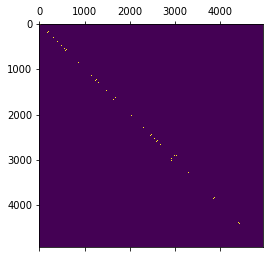

In [231]:
import matplotlib.pyplot as plt
plt.matshow(A1)
print(np.shape(A1))


# Generating Labels

In [232]:
from numpy import nan


def returnLabels(direc, files):
    train_text = []
    labels = []
    for f in range(len(files)):
        seenList = []
        df = pd.read_csv(direc + files[f])
        text = df['Object'].to_list()
        T_labels = df['labels'].to_list()

        for i in range(len(text)):
            if(text[i] not in seenList):
                labels.append(T_labels[i])
                train_text.append(text[i])
            seenList.append(text[i])

    return labels, train_text


# Encoding Labels
1. Get a list of labels from CSV files.
2. Catagorically encode the labels 

In [233]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

b1_labels, b1_text = returnLabels(lab_files_path, Batch_1)
print("Total train labels are: ", len(b1_labels))
print("Total train text is: ", len(b1_text))

lab_encoder = LabelEncoder()
b1_encodings = lab_encoder.fit_transform(b1_labels)
print("Total train encodings are: ", len(b1_encodings))


uni_b1_enc = set(b1_encodings)
print("Unique train encodings are: ", uni_b1_enc)
print("=============================================")

b2_labels, b2_text = returnLabels(lab_files_path, Batch_2)
print("Total train labels are: ", len(b2_labels))
print("Total train text is: ", len(b2_text))

lab_encoder = LabelEncoder()
b2_encodings = lab_encoder.fit_transform(b2_labels)
print("Total train encodings are: ", len(b2_encodings))


uni_b2_enc = set(b2_encodings)
print("Unique train encodings are: ", uni_b2_enc)
print("=============================================")

b3_labels, b3_text = returnLabels(lab_files_path, Batch_3)
print("Total train labels are: ", len(b3_labels))
print("Total train text is: ", len(b3_text))

lab_encoder = LabelEncoder()
b3_encodings = lab_encoder.fit_transform(b3_labels)
print("Total train encodings are: ", len(b3_encodings))


uni_b3_enc = set(b3_encodings)
print("Unique train encodings are: ", uni_b3_enc)
print("=============================================")

b4_labels, b4_text = returnLabels(lab_files_path, Batch_4)
print("Total train labels are: ", len(b4_labels))
print("Total train text is: ", len(b4_text))

lab_encoder = LabelEncoder()
b4_encodings = lab_encoder.fit_transform(b4_labels)
print("Total train encodings are: ", len(b4_encodings))


uni_b4_enc = set(b4_encodings)
print("Unique train encodings are: ", uni_b4_enc)
print("=============================================")

valid_labels, valid_text = returnLabels(lab_files_path, valid_set)
print("Total validation labels are: ", len(valid_labels))

lab_encoder = LabelEncoder()
valid_encodings = lab_encoder.fit_transform(valid_labels)
print("Total train encodings are: ", len(valid_encodings))


uni_valid_enc = set(valid_encodings)
print("Unique validation encodings are: ", uni_valid_enc)
print("=============================================")


Total train labels are:  4938
Total train text is:  4938
Total train encodings are:  4938
Unique train encodings are:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Total train labels are:  2460
Total train text is:  2460
Total train encodings are:  2460
Unique train encodings are:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Total train labels are:  856
Total train text is:  856
Total train encodings are:  856
Unique train encodings are:  {0, 1, 2, 3, 4, 5, 6, 7, 8}
Total train labels are:  451
Total train text is:  451
Total train encodings are:  451
Unique train encodings are:  {0, 1, 2, 3, 4, 5, 6, 7, 8}
Total validation labels are:  956
Total train encodings are:  956
Unique validation encodings are:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


# Deep Learning Libraries

In [234]:
# from tensorflow.keras import Sequential

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense, Flatten, Activation
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.regularizers import l2


from spektral.utils.sparse import sp_matrix_to_sp_tensor
from spektral.layers import GCNConv
from sklearn.metrics import classification_report
from spektral.utils import normalized_laplacian
from spektral.utils.sparse import sp_matrix_to_sp_tensor

import matplotlib.pyplot as plt
print("Libraries Imported..")


Libraries Imported..


# Model Hyperparameters

In [235]:
# Hyper-parameters
dropout = 0.5
learning_rate = 1e-4
l2_reg = 0.001
batch_size = 16
es_patience = 10


# Embeddings for train matrix

In [236]:
from gensim.models import Word2Vec
Emb_Model = "./Model/Word2Vec_Model.bin"
Loaded_model = Word2Vec.load(Emb_Model)

train_embeddings = []
for t in b1_text:
    train_embeddings.append(Loaded_model.wv[t])
    
print(len(train_embeddings))
    
print("Total train test is: ", len(b1_text))


4938
Total train test is:  4938


# Model Definition

In [237]:

N = A1.shape[0]
F = np.shape(train_embeddings)[1]
train_embeddings = np.array(train_embeddings)
print(F)

classes = len(set(b1_labels))
print("Total classes are: ", classes)

# X_in = Input(batch_size=N, shape=(F))
X_in = Input(batch_size=None, shape=(F,))
print("Shape of X-in is: ", np.shape(X_in))

# A_in = Input(tensor=sp_matrix_to_sp_tensor(fltr), sparse=True)
# A_in = Input(shape=(None,), sparse=True)
A_in = Input(shape=(None,))
print("Shape of A-in is: ", np.shape(A_in))

# D1 = Dropout(dropout)(X_in)
# G1 = GCNConv(channels, activation='LeakyReLU',
            #  kernel_regularizer=l2(l2_reg), use_bias=True)([X_in, A_in])
G1 = GCNConv(512, activation='LeakyReLU', use_bias=True)([X_in, A_in])
# D2 = Dropout(dropout)(G1)
# G2 = GCNConv(channels, activation='LeakyReLU',
#              kernel_regularizer=l2(l2_reg), use_bias=True)([G1, A_in])
G2 = GCNConv(256, activation='LeakyReLU', use_bias=True)([G1, A_in])

# # BN = BatchNormalization()(G2)
flatten = Flatten()(G2)

D1 = Dense(256, activation='relu')(flatten)
# Dr1 = Dropout(dropout)(D1)
D2 = Dense(64, activation='relu')(D1)
# Dr2 = Dropout(dropout)(D2)
# D3 = Dense(16, activation='LeakyReLU')(D2)

D2_out = Dense(classes, activation='softmax')(D2)

model = Model(inputs=[X_in, A_in], outputs=D2_out)

# global_step = tf.Variable(0, trainable=False)
# learning_rate = tf.compat.v1.train.exponential_decay(0.0001,global_step,10000, 0.96, staircase=True)
opt = tf.optimizers.Adam(learning_rate)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy', weighted_metrics=['acc'])

model.summary()


100
Total classes are:  10
Shape of X-in is:  (None, 100)
Shape of A-in is:  (None, None)
Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_39 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_40 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 gcn_conv_38 (GCNConv)          (None, 512)          51712       ['input_39[0][0]',               
                                                                  'input_40[0][0]']               
                                                                                                  
 

# Training Model

In [238]:
validation_text = []
for i in range(len(valid_set)):
    df = pd.read_csv(lab_files_path+valid_set[i])
    Text = df['Object'].to_list()

    for T in Text:
        validation_text.append(T)


valid_embeddings = []
for t in valid_text:
    valid_embeddings.append(Loaded_model.wv[t])
    
valid_embeddings = np.array(valid_embeddings)

callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)

checkpoint = ModelCheckpoint(
    "./Model/Model-{val_acc:.4f}.h5", monitor='val_acc', save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_loss',
                            min_delta=0,
                            patience=10,
                            verbose=1,
                            restore_best_weights=True
                            )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                                        factor=0.05,
                                        patience=10,
                                        verbose=1,
                                        mode = "min",
                                        min_delta=0.00001)

history = model.fit([train_embeddings, A1],
                    b1_encodings,
                    epochs=80,
                    batch_size=N,
                    # class_weight=W,
                    validation_data=([valid_embeddings, A4], valid_encodings),
                    # callbacks=[checkpoint]
                    )


Epoch 1/80
1/1 [==============================] - 2s 2s/step - loss: 3.5848 - acc: 0.1442 - val_loss: 4.3345 - val_acc: 0.1130
Epoch 2/80
1/1 [==============================] - 1s 994ms/step - loss: 3.0536 - acc: 0.1517 - val_loss: 3.8771 - val_acc: 0.1151
Epoch 3/80
1/1 [==============================] - 1s 1s/step - loss: 2.7294 - acc: 0.1561 - val_loss: 3.5991 - val_acc: 0.1182
Epoch 4/80
1/1 [==============================] - 1s 973ms/step - loss: 2.5658 - acc: 0.1454 - val_loss: 3.4894 - val_acc: 0.1192
Epoch 5/80
1/1 [==============================] - 1s 1s/step - loss: 2.4492 - acc: 0.1602 - val_loss: 3.4679 - val_acc: 0.1203
Epoch 6/80
1/1 [==============================] - 1s 911ms/step - loss: 2.4030 - acc: 0.1634 - val_loss: 3.4646 - val_acc: 0.1224
Epoch 7/80
1/1 [==============================] - 1s 939ms/step - loss: 2.3466 - acc: 0.1685 - val_loss: 3.4751 - val_acc: 0.1234
Epoch 8/80
1/1 [==============================] - 1s 972ms/step - loss: 2.2840 - acc: 0.1784 - val_

# Losses

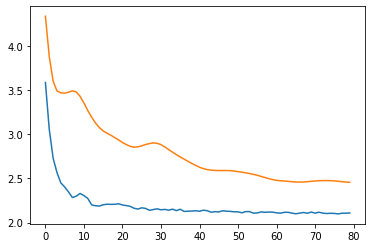

In [239]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Accuracy

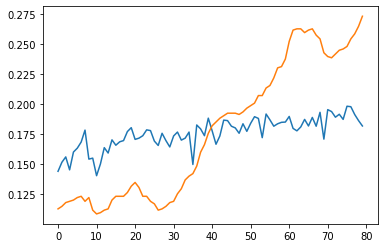

In [240]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

# Saving Model

In [241]:
model.save(
    "./Model/Model-{val_acc:03f}.h5")


# Loading Model

In [249]:
from keras.models import load_model
model = load_model("./Model/Model-{val_acc:03f}.h5",
                   custom_objects={"GCNConv": GCNConv})
# model.summary()


# Training on Batch-2

In [253]:
b2_embeddings = []
# print(len(b2_text))

for t2 in b2_text:
    b2_embeddings.append(Loaded_model.wv[t2])

b2_embeddings=np.array(b2_embeddings)


history = model.fit([b2_embeddings, A2],
                    b2_encodings,
                    epochs=100,
                    batch_size=N,
                    # class_weight=W,
                    validation_data=([valid_embeddings, A4], valid_encodings),
                    # callbacks=[reduce_learningrate]
                    )


Epoch 1/100
1/1 [==============================] - 0s 393ms/step - loss: 2.1905 - acc: 0.2065 - val_loss: 2.2746 - val_acc: 0.1695
Epoch 2/100
1/1 [==============================] - 0s 365ms/step - loss: 2.1819 - acc: 0.1870 - val_loss: 2.2755 - val_acc: 0.1611
Epoch 3/100
1/1 [==============================] - 0s 360ms/step - loss: 2.1702 - acc: 0.2102 - val_loss: 2.2745 - val_acc: 0.1621
Epoch 4/100
1/1 [==============================] - 0s 316ms/step - loss: 2.1623 - acc: 0.2154 - val_loss: 2.2713 - val_acc: 0.1642
Epoch 5/100
1/1 [==============================] - 0s 324ms/step - loss: 2.1692 - acc: 0.2065 - val_loss: 2.2673 - val_acc: 0.1747
Epoch 6/100
1/1 [==============================] - 0s 313ms/step - loss: 2.1658 - acc: 0.2049 - val_loss: 2.2620 - val_acc: 0.1778
Epoch 7/100
1/1 [==============================] - 0s 320ms/step - loss: 2.1587 - acc: 0.2228 - val_loss: 2.2546 - val_acc: 0.1768
Epoch 8/100
1/1 [==============================] - 0s 325ms/step - loss: 2.1514 - a

# Checking loss for Batch-2

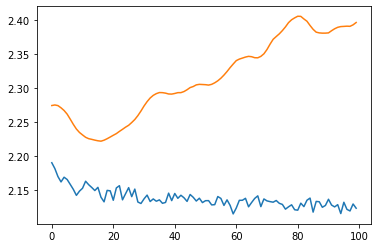

In [254]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])


# Checking accuracy for Batch-2

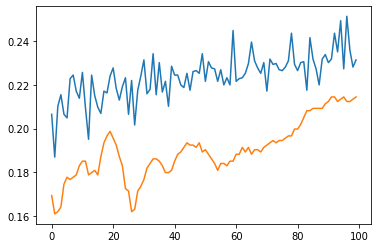

In [255]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

# Saving Second Batch-Training

In [256]:
model.save(
    "./Model/IDS_Batch1_{val_acc:03f}.h5")


# Loading Model

In [264]:
from keras.models import load_model
model = load_model("./Model/IDS_Batch1_{val_acc:03f}.h5",
                   custom_objects={"GCNConv": GCNConv})
# model.summary()


# Training Batch-3

In [265]:
b3_embeddings = []
# print(len(b2_text))

for t3 in b3_text:
    b3_embeddings.append(Loaded_model.wv[t3])

b3_embeddings = np.array(b3_embeddings)


history = model.fit([b3_embeddings, A3],
                    b3_encodings,
                    epochs=3,
                    batch_size=N,
                    # class_weight=W,
                    validation_data=([valid_embeddings, A4], valid_encodings),
                    # callbacks=[reduce_learningrate]
                    )


Epoch 1/3
1/1 [==============================] - 1s 582ms/step - loss: 3.1028 - acc: 0.2021 - val_loss: 2.3433 - val_acc: 0.2186
Epoch 2/3
1/1 [==============================] - 0s 110ms/step - loss: 2.7950 - acc: 0.1998 - val_loss: 2.2844 - val_acc: 0.2144
Epoch 3/3
1/1 [==============================] - 0s 118ms/step - loss: 2.5102 - acc: 0.1636 - val_loss: 2.2462 - val_acc: 0.2050


# Checking-Loss

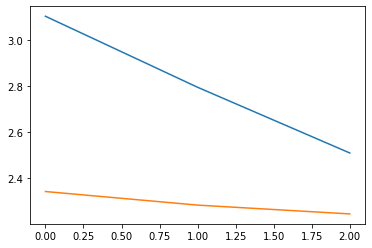

In [266]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])


# Checking Accuracy

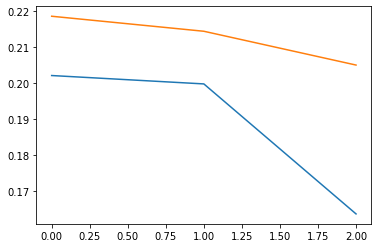

In [267]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])


# Saving Model

In [268]:
model.save(
    "./Model/IDS_Batch1_{val_acc:03f}.h5")


# Loading Model

In [278]:
from keras.models import load_model
model = load_model("./Model/IDS_Batch1_{val_acc:03f}.h5",
                   custom_objects={"GCNConv": GCNConv})
# model.summary()
# 

# Training Batch-4

In [279]:
b4_embeddings = []
# print(len(b2_text))

for t4 in b4_text:
    b4_embeddings.append(Loaded_model.wv[t4])

b4_embeddings = np.array(b4_embeddings)

valid_embeddings = []
for t in valid_text:
    valid_embeddings.append(Loaded_model.wv[t])

valid_embeddings = np.array(valid_embeddings)

callback = tf.keras.callbacks.EarlyStopping(monitor="val_acc", patience=25)

history = model.fit([b4_embeddings, A6],
                    b4_encodings,
                    epochs=1,
                    batch_size=N,
                    # class_weight=W,
                    validation_data=([valid_embeddings, A4], valid_encodings),
                    # callbacks=[callback]
                    )


1/1 [==============================] - 1s 555ms/step - loss: 2.3671 - acc: 0.1397 - val_loss: 2.2273 - val_acc: 0.1935
